In [13]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
from scipy.signal import argrelextrema

# Set rcParams to customize tick labels and spines
plt.rcParams['xtick.labelsize'] = 11
plt.rcParams['ytick.labelsize'] = 11
plt.rcParams['axes.labelsize'] = 11
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.grid'] = True
plt.rcParams['legend.fontsize'] = 11
plt.rcParams['legend.loc'] = 'upper right'
plt.rcParams['axes.titlesize'] = 12

In [2]:
source_directory = f"D:/Courses/Uclouvain/thesis/code/these_Colin/seismogram_curve_extraction/data/ground_truths/overlap_0_images/"

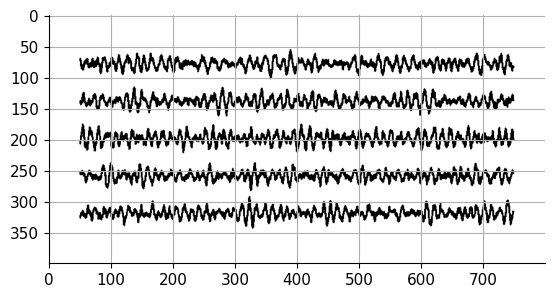

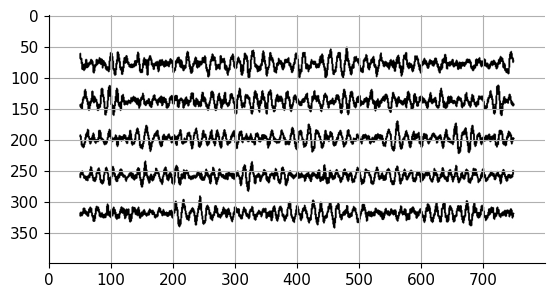

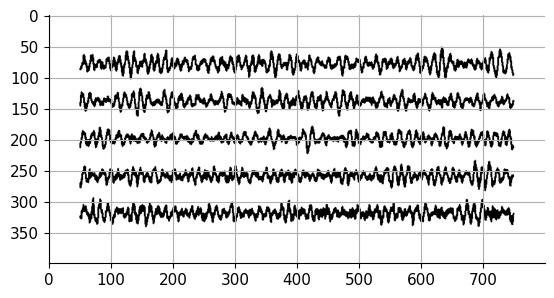

In [3]:
count = 0
saved_images = []  # List to store images

for image_file in os.listdir(source_directory):
    if image_file.endswith('_binary.jpg'):
        image_file = os.path.join(source_directory, image_file)
        saved_images.append(cv2.imread(image_file, cv2.IMREAD_GRAYSCALE))
        if count < 3:
            plt.imshow(cv2.imread(image_file, cv2.IMREAD_GRAYSCALE), cmap='gray')
            plt.show()
            count += 1

saved_images = np.array(saved_images)


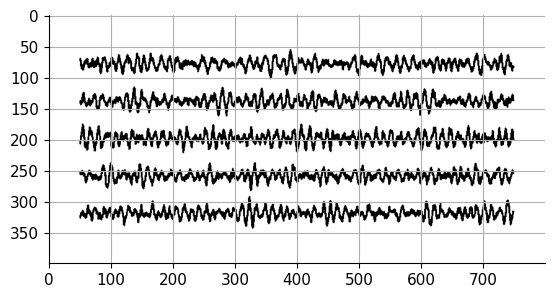

In [4]:
plt.imshow(saved_images[0], cmap='gray')

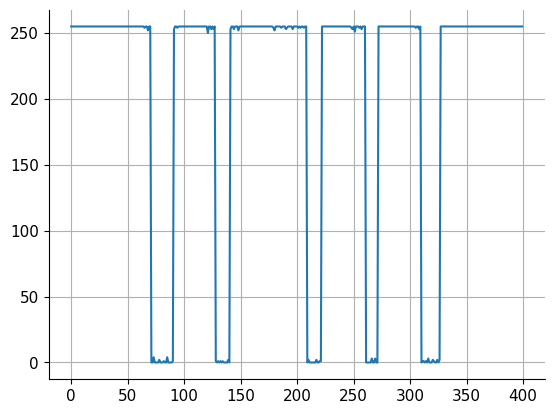

In [5]:
# plot one column of the image
plt.plot(saved_images[0][:, len(saved_images[0][0])//2])
plt.show()

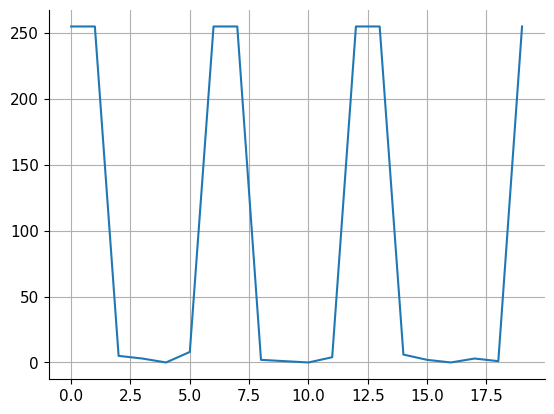

Number of connected components: 3
Average thickness: 4.333333333333333


In [6]:
def count_components_and_avg_thickness(arr, threshold=10):
    """
    Counts the number of connected components where values are close to 0 
    and computes the average thickness.

    Parameters:
    - arr: 1D numpy array containing grayscale values (0 to 255).
    - threshold: Defines what is considered "close to 0" (default: 10).

    Returns:
    - count: Number of connected components.
    - avg_thickness: Average thickness of components.
    """
    count = 0
    thicknesses = []
    n = len(arr)
    
    i = 0
    while i < n:
        if arr[i] < threshold:  # Found a new component (close to 0)
            count += 1
            start = i
            while i < n and arr[i] < threshold:  # Continue until background (255)
                i += 1
            thicknesses.append(i - start)
        else:
            i += 1

    avg_thickness = np.mean(thicknesses) if thicknesses else 0
    return count, avg_thickness

# Example usage
binary_array = np.array([255, 255, 5, 3, 0, 8, 255, 255, 2, 1, 0, 4, 255, 255, 6, 2, 0, 3, 1, 255])
num_components, avg_thickness = count_components_and_avg_thickness(binary_array)

plt.plot(binary_array)
plt.show()

print(f"Number of connected components: {num_components}")
print(f"Average thickness: {avg_thickness}")


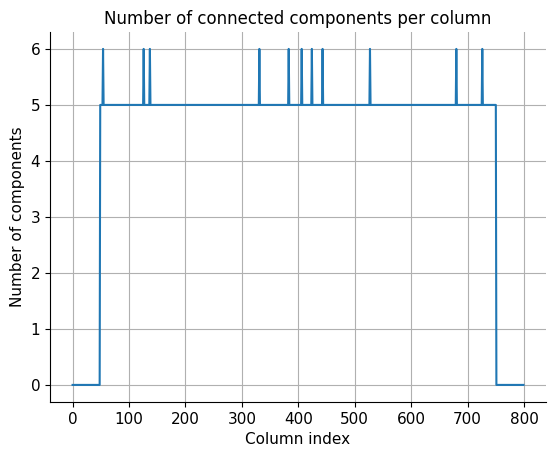

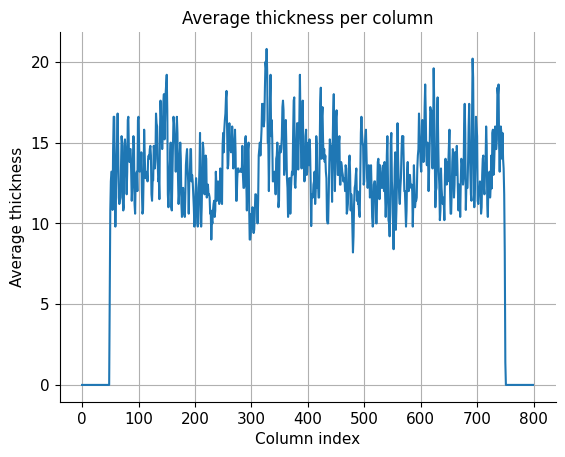

Average number of components: 5 VS true value is 5
Average thickness: 13 VS true value is 15


In [7]:
# apply to the columns of the image and compute the average thickness, average number of components
N_components = []
thickness = []

for i in range(saved_images.shape[2]):
    n, t = count_components_and_avg_thickness(saved_images[0][:, i])
    N_components.append(n)
    thickness.append(t)

plt.plot(N_components)
plt.title("Number of connected components per column")
plt.xlabel("Column index")
plt.ylabel("Number of components")
plt.show()

plt.plot(thickness)
plt.title("Average thickness per column")
plt.xlabel("Column index")
plt.ylabel("Average thickness")
plt.show()

# compute the average thickness and number of components for all images by ignoring the columns with no components
N_components = np.array(N_components)
thickness = np.array(thickness)
N_components = N_components[N_components > 1e-6]
thickness = thickness[thickness > 1e-6]

avg_N_components = int(np.mean(N_components))
avg_thickness = int(np.mean(thickness))
print(f"Average number of components: {int(np.mean(N_components))} VS true value is 5")
print(f"Average thickness: {int(np.mean(thickness))} VS true value is 15")


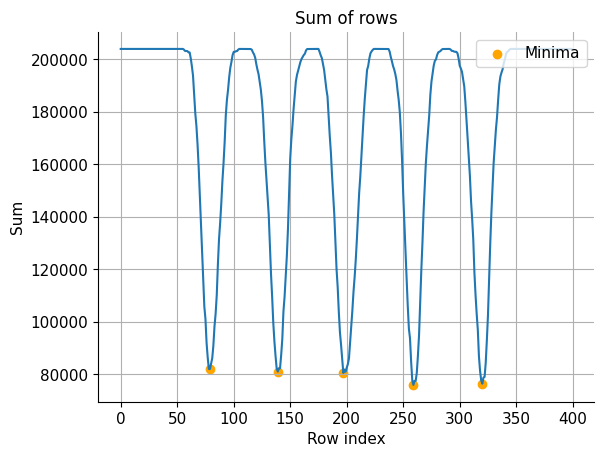

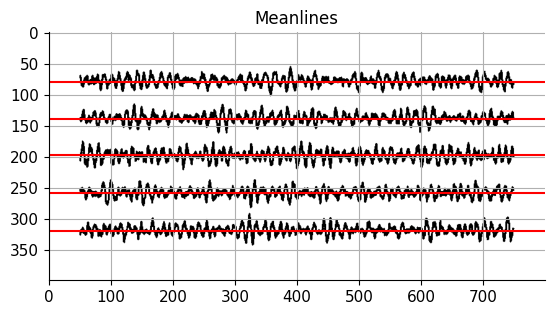

In [14]:
# find the meanlines of each curves in the image
# sum the rows of the image
sum_rows = np.sum(saved_images[0], axis=1)

# Find local minima
min_indices = argrelextrema(sum_rows, np.less, order=10)[0]
sorted_minima = min_indices[np.argsort(sum_rows[min_indices])]

plt.plot(sum_rows)
plt.scatter(sorted_minima[:avg_N_components], sum_rows[sorted_minima[:avg_N_components]], color='orange', label="Minima")
plt.legend()
plt.title("Sum of rows")
plt.xlabel("Row index")
plt.ylabel("Sum")
plt.show()

# The meanlines are the num_components rows with the minimum sum
meanlines = sorted_minima[:avg_N_components]

plt.imshow(saved_images[0], cmap='gray')
for meanline in meanlines:
    plt.axhline(meanline, color='r')
plt.title("Meanlines")
plt.show()

In [ ]:
# Find the starting point of each component
starting_points = []

# iterate over the columns of the image until